In [1]:
#Importing required Packages
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

import helper
import zipfile
from PIL import Image

import time
import seaborn as sns
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [2]:
train_transforms = transforms.Compose([transforms.RandomCrop((256,256)),
                                       transforms.RandomRotation(30),
                                       transforms.ColorJitter(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224), 
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.RandomCrop((256,256)),
                                       transforms.CenterCrop(224), 
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([ transforms.RandomCrop((256,256)),
                                       transforms.CenterCrop(224), 
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
train_set = DatasetFolder('flower102/train', loader=lambda x: Image.open(x), extensions="jpg", transform = train_transforms)
valid_set = DatasetFolder('flower102/valid', loader=lambda x: Image.open(x), extensions="jpg", transform = valid_transforms)
test_set = DatasetFolder('flower102/test', loader=lambda x: Image.open(x), extensions="jpg", transform = test_transforms)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=0)

Debugger :  class -> idx 
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '80': 80, '81': 81, '82': 82, '83': 83, '84': 84, '85': 85, '86': 86, '87': 87, '88': 88, '89': 89, '90': 90, '91': 91, '92': 92, '93': 93, '94': 94, '95': 95, '96': 96, '97': 97, '98': 98, '99

In [4]:
model = models.densenet201(weights='DenseNet201_Weights.DEFAULT')

#Freeze denseblock layers for retraining, Optional
for name, child in model.features.named_children():
    if name in ['conv0', 'norm0','relu0','pool0','denseblock1','transition1','denseblock2','transition2','transition3','norm5']:
        #print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

    else:
        #print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True

            
# * Define a new, untrained feed-forward network as a classifier
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class ClassifierH2(nn.Module):
    def __init__(self, inp = 1920, h1=1024, output = 102, drop=0.35):
        super().__init__()
        self.adaptivePool = nn.AdaptiveAvgPool2d((1,1))
        self.maxPool = nn.AdaptiveMaxPool2d((1,1))
        
        self.fla = Flatten()
        self.batchN0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(drop)
        self.fc1 = nn.Linear(inp*2, h1)
        self.batchN1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(drop)

        self.fc3 = nn.Linear(h1, output)
        
    def forward(self, x):
        adaptivePool = self.adaptivePool(x)
        maxPool = self.maxPool(x)
        x = torch.cat((adaptivePool,maxPool),dim=1)
        x = self.fla(x)
        x = self.batchN0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.batchN1(x)
        x = self.dropout1(x)         
        x = self.fc3(x)
        
        return x

In [5]:
#Set Model
model = nn.Sequential(*list(model.children())[:-1],ClassifierH2())
     
model = model.to(device)

# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
sched = lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=0.1)

n_epochs = 50
best_acc = 0

train_loss, valid_loss = [], []
for epoch in range(n_epochs):
    print(f'Epoch : {epoch} | Training')
    model.train()
    t_loss = 0
    train_total = 0
    for batch in tqdm(train_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        
        train_total += imgs.shape[0]
        
        optimizer.zero_grad()
        outputs = model(imgs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        sched.step()
        t_loss += loss.item()
    
    v_loss = 0
    accuracy = 0
    model.eval()
    eval_total = 0
    print(f'Epoch : {epoch} | Evaluating')
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            
            eval_total += imgs.shape[0]
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            loss = criterion(outputs, labels)
            
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            
            accuracy += torch.sum(preds == labels.data)
    train_loss.append(t_loss/train_total)
    valid_loss.append(v_loss/eval_total)
    
    accuracy = accuracy/eval_total
    
    print(f'Epoch: Accuracy = {accuracy} | Train loss = {t_loss/train_total} | validation loss = {v_loss/eval_total}')
    
    v_loss = v_loss/eval_total
    
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), f'./pretrain/flower102_20230520{epoch}.pt')

Epoch : 0 | Training


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch : 0 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.7359413504600525 | Train loss = 0.015008759294819629 | validation loss = 0.011472495814698832
Epoch : 1 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 1 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.7640587091445923 | Train loss = 0.009215596813130873 | validation loss = 0.009301862463100032
Epoch : 2 | Training


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch : 2 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: Accuracy = 0.787286102771759 | Train loss = 0.008686496433830378 | validation loss = 0.008454420455802041
Epoch : 3 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 3 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.7982885241508484 | Train loss = 0.008344013876166827 | validation loss = 0.008196226833502063
Epoch : 4 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 4 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.8105134963989258 | Train loss = 0.007932884670948662 | validation loss = 0.007792555761220694
Epoch : 5 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 5 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.8141809701919556 | Train loss = 0.0073972540260525705 | validation loss = 0.007296504266104663
Epoch : 6 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 6 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.8251833915710449 | Train loss = 0.007054037190473415 | validation loss = 0.0071364335879719925
Epoch : 7 | Training


100%|██████████| 52/52 [00:38<00:00,  1.34it/s]


Epoch : 7 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Epoch: Accuracy = 0.8422983288764954 | Train loss = 0.006769287134992625 | validation loss = 0.006517834870331445
Epoch : 8 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 8 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.8276283740997314 | Train loss = 0.00649079785969959 | validation loss = 0.0065660040215350015
Epoch : 9 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 9 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: Accuracy = 0.8496332764625549 | Train loss = 0.006185918928138794 | validation loss = 0.006230093083346677
Epoch : 10 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 10 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.8606357574462891 | Train loss = 0.005981593669115842 | validation loss = 0.005579429762870583
Epoch : 11 | Training


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch : 11 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.854523241519928 | Train loss = 0.005674420559144282 | validation loss = 0.005981083604117769
Epoch : 12 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 12 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.8655257225036621 | Train loss = 0.00541115574929886 | validation loss = 0.005521097728267567
Epoch : 13 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 13 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Epoch: Accuracy = 0.8606357574462891 | Train loss = 0.005260251180447356 | validation loss = 0.005718948497165969
Epoch : 14 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 14 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.8814181089401245 | Train loss = 0.00519173201150801 | validation loss = 0.005292563756112656
Epoch : 15 | Training


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch : 15 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.878973126411438 | Train loss = 0.004848114027208461 | validation loss = 0.004993528783467113
Epoch : 16 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 16 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: Accuracy = 0.8801956176757812 | Train loss = 0.004827712108727922 | validation loss = 0.004894901094343377
Epoch : 17 | Training


100%|██████████| 52/52 [00:38<00:00,  1.33it/s]


Epoch : 17 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Epoch: Accuracy = 0.8924205899238586 | Train loss = 0.004578932073599544 | validation loss = 0.004742292291086286
Epoch : 18 | Training


100%|██████████| 52/52 [00:38<00:00,  1.34it/s]


Epoch : 18 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.8826406002044678 | Train loss = 0.004534935594623924 | validation loss = 0.004440575072992693
Epoch : 19 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 19 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.8850856423377991 | Train loss = 0.004291865888241592 | validation loss = 0.004669018800217832
Epoch : 20 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 20 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.8875306248664856 | Train loss = 0.004163399320527893 | validation loss = 0.004501025367774124
Epoch : 21 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 21 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: Accuracy = 0.898533046245575 | Train loss = 0.004051234600417343 | validation loss = 0.004499382013796594
Epoch : 22 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 22 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.9046455025672913 | Train loss = 0.003919480607295647 | validation loss = 0.0038430069944386377
Epoch : 23 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 23 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.898533046245575 | Train loss = 0.0037810254719231155 | validation loss = 0.004179630965941692
Epoch : 24 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 24 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.9132030010223389 | Train loss = 0.003567524267967804 | validation loss = 0.0037493256893018057
Epoch : 25 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 25 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.8911980986595154 | Train loss = 0.003595274451196703 | validation loss = 0.004297345111597429
Epoch : 26 | Training


100%|██████████| 52/52 [00:38<00:00,  1.34it/s]


Epoch : 26 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9180929660797119 | Train loss = 0.0034910961303300475 | validation loss = 0.0038272613126666155
Epoch : 27 | Training


100%|██████████| 52/52 [00:38<00:00,  1.34it/s]


Epoch : 27 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: Accuracy = 0.908312976360321 | Train loss = 0.0034717770795973523 | validation loss = 0.003944130609845766
Epoch : 28 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 28 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Epoch: Accuracy = 0.9046455025672913 | Train loss = 0.003289175493886037 | validation loss = 0.004077085546584467
Epoch : 29 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 29 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch: Accuracy = 0.9156479835510254 | Train loss = 0.003307669540646603 | validation loss = 0.003430890862108151
Epoch : 30 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 30 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Epoch: Accuracy = 0.9119805097579956 | Train loss = 0.003167461879069261 | validation loss = 0.0035961239728484586
Epoch : 31 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 31 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.9095354676246643 | Train loss = 0.0030670823331499274 | validation loss = 0.0035437041287900185
Epoch : 32 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 32 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.9168704748153687 | Train loss = 0.0029810870154982523 | validation loss = 0.0034492297831257863
Epoch : 33 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 33 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9009780287742615 | Train loss = 0.003042875524150874 | validation loss = 0.004010432761863858
Epoch : 34 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 34 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9144254922866821 | Train loss = 0.0028296512266182054 | validation loss = 0.003676192648253406
Epoch : 35 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 35 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.9156479835510254 | Train loss = 0.0028807799762822187 | validation loss = 0.003282607075346128
Epoch : 36 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 36 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.908312976360321 | Train loss = 0.0026998386419263367 | validation loss = 0.0035031381038115486
Epoch : 37 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 37 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Epoch: Accuracy = 0.9119805097579956 | Train loss = 0.0027617761212536413 | validation loss = 0.003122238683671415
Epoch : 38 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 38 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9144254922866821 | Train loss = 0.0026191996776650096 | validation loss = 0.003329543510684174
Epoch : 39 | Training


100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


Epoch : 39 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch: Accuracy = 0.9388753175735474 | Train loss = 0.002600963692543562 | validation loss = 0.0026835117370691743
Epoch : 40 | Training


100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


Epoch : 40 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9168704748153687 | Train loss = 0.0024163511369072617 | validation loss = 0.002844776347971779
Epoch : 41 | Training


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch : 41 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: Accuracy = 0.9254279136657715 | Train loss = 0.0024669010178510085 | validation loss = 0.0031722568358069237
Epoch : 42 | Training


100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


Epoch : 42 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch: Accuracy = 0.9205379486083984 | Train loss = 0.0024174773344663183 | validation loss = 0.002853133330863962
Epoch : 43 | Training


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch : 43 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch: Accuracy = 0.9107579588890076 | Train loss = 0.002374178933500516 | validation loss = 0.0031391725417745727
Epoch : 44 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 44 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9290953874588013 | Train loss = 0.0023073148396280077 | validation loss = 0.0028021746567817073
Epoch : 45 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 45 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Epoch: Accuracy = 0.9107579588890076 | Train loss = 0.002185553742142824 | validation loss = 0.003051502088171346
Epoch : 46 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 46 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9254279136657715 | Train loss = 0.0021922092348046064 | validation loss = 0.0028354740703892883
Epoch : 47 | Training


100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch : 47 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9339853525161743 | Train loss = 0.0021451440945686145 | validation loss = 0.002403123928165669
Epoch : 48 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 48 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch: Accuracy = 0.9193154573440552 | Train loss = 0.002171048432843298 | validation loss = 0.0030513189569079204
Epoch : 49 | Training


100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


Epoch : 49 | Evaluating


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

Epoch: Accuracy = 0.932762861251831 | Train loss = 0.0020868643238158018 | validation loss = 0.0023893109342871203


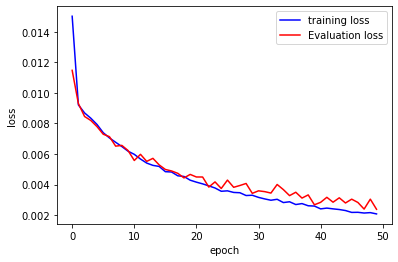

In [6]:
epochs = np.arange(n_epochs)
plt.figure(0)
plt.plot(epochs, train_loss, color = 'b', label = 'training loss')
plt.plot(epochs, valid_loss, color = 'r', label = 'Evaluation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.savefig(f'./pretrain/loss_surface.png')
#plt.clf()

In [9]:
torch.cuda.empty_cache()
model = models.densenet201(weights='DenseNet201_Weights.DEFAULT')
model = nn.Sequential(*list(model.children())[:-1],ClassifierH2())
model = model.to(device)
checkpoint = torch.load(f'./pretrain/flower102_2023052039.pt')
model.load_state_dict(checkpoint)
model.eval()   
    
equals = 0
total = 0 
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # obtain the outputs from the model
        #print(imgs.shape)
        total += imgs.shape[0]

        outputs = model(imgs)
        # max provides the (maximum probability, max value)
        _, predicted = outputs.max(dim=1)
        #print(outputs)
        #print(predicted)
        #print(labels)
        #print(torch.sum(predicted == labels.data))
        equals += torch.sum(predicted == labels.data)
#print(equals)
#print(total)
        
print(f'Test accuracy = {equals/total}')

100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


Test accuracy = 0.8864468932151794


In [8]:
print(best_acc)

tensor(0.9389, device='cuda:0')
